In [ ]:
# default_exp timeseries.learner

# timeseries.learner

> API details.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.model import *
from fastrenewables.timeseries.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from fastrenewables.losses import VILoss
import pandas as pd

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
class RenewableTimeseriesLearner(Learner):
    "`Learner` for renewable timerseries data."
    def predict(self, ds_idx=1, test_dl=None, filter=True, as_df=False):
        device = next(self.model.parameters()).device
        preds, targets = None, None
        if test_dl is not None:
            to = test_dl.train_ds
        elif ds_idx == 0:
            to = self.dls.train_ds
        elif ds_idx == 1:
            to = self.dls.valid_ds
            
        # to increase speed we direclty predict on all tensors   
        if isinstance(to, (TimeseriesDataset)):
            with torch.no_grad():
                preds = self.model(to.cats.to(device), to.conts.to(device))

            preds, targets = to_np(preds).reshape(-1), to_np(to.ys).reshape(-1)
            if filter:
                preds[preds < 0] = 0
                preds[preds > 1.1] = 1.1
        else:
            raise NotImplementedError("Unknown type")
        
        if as_df:
            return pd.DataFrame({"Prediction": preds, "Target":targets}, index=to.indexes.reshape(-1))
        else:
            return preds, targets

In [ ]:
show_doc(RenewableTimeseriesLearner, title_level=3)

<h3 id="RenewableTimeseriesLearner" class="doc_header"><code>class</code> <code>RenewableTimeseriesLearner</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RenewableTimeseriesLearner</code>(**`dls`**, **`model`**, **`loss_func`**=*`None`*, **`opt_func`**=*`Adam`*, **`lr`**=*`0.001`*, **`splitter`**=*`trainable_params`*, **`cbs`**=*`None`*, **`metrics`**=*`None`*, **`path`**=*`None`*, **`model_dir`**=*`'models'`*, **`wd`**=*`None`*, **`wd_bn_bias`**=*`False`*, **`train_bn`**=*`True`*, **`moms`**=*`(0.95, 0.85, 0.95)`*) :: `Learner`

`Learner` for renewable data

In [ ]:
def get_dls():
#     cat_names = ['TaskID', 'Month', 'Day', 'Hour']
    cat_names = ['TaskID', 'Day', 'Hour']
    cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
           'ASWDIRS_SFC_0_M', 'WindSpeed58m']
    y_names="PowerGeneration"
#     y_names="Month"
    
    pd.options.mode.chained_assignment=None
    
    dls = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5"), 
                                                    y_names=y_names, 
                                                    cat_names=cat_names, 
                                                    cont_names=cont_names,
                                      pre_procs=[FilterYear(year=2020), 
                                                 AddSeasonalFeatures(as_cont=False),
                                                 FilterInconsistentSamplesPerDay], 
                                      procs=Categorify, 
                                      bs=13,
                                      y_block=RegressionBlock())
    return dls



In [ ]:
dls = get_dls()

In [ ]:
dls.train_ds.loss_func

FlattenedLoss of MSELoss()

In [ ]:
dls.train_ds.c

1

In [ ]:
dls.train_ds

index:
 [[['2019-08-10T00:00:00.000000000' '2019-08-10T01:00:00.000000000'
   '2019-08-10T02:00:00.000000000' ... '2019-08-10T21:00:00.000000000'
   '2019-08-10T22:00:00.000000000' '2019-08-10T23:00:00.000000000']]

 [['2019-01-14T00:00:00.000000000' '2019-01-14T01:00:00.000000000'
   '2019-01-14T02:00:00.000000000' ... '2019-01-14T21:00:00.000000000'
   '2019-01-14T22:00:00.000000000' '2019-01-14T23:00:00.000000000']]

 [['2019-09-20T00:00:00.000000000' '2019-09-20T01:00:00.000000000'
   '2019-09-20T02:00:00.000000000' ... '2019-09-20T21:00:00.000000000'
   '2019-09-20T22:00:00.000000000' '2019-09-20T23:00:00.000000000']]

 ...

 [['2019-11-12T00:00:00.000000000' '2019-11-12T01:00:00.000000000'
   '2019-11-12T02:00:00.000000000' ... '2019-11-12T21:00:00.000000000'
   '2019-11-12T22:00:00.000000000' '2019-11-12T23:00:00.000000000']]

 [['2019-06-13T00:00:00.000000000' '2019-06-13T01:00:00.000000000'
   '2019-06-13T02:00:00.000000000' ... '2019-06-13T21:00:00.000000000'
   '2019-06-13T2

In [ ]:
#export
@delegates(Learner.__init__)
def renewable_timeseries_learner(dls, layers=None, emb_szs=None, config=None, 
                                 n_out=None, y_range=None, 
                                 embedding_type=EmbeddingType.Normal, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    
#     if n_out is None: 
#         n_out = get_c(dls)
    n_out = dls.train_ds.ys.shape[1]
        
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    
    if layers is None: layers = [len(dls.cont_names), 200, 100, n_out]
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
        
    embed_p = kwargs["embed_p"].pop() if "embed_p" in kwargs.keys() else 0.1
    
    emb_module = None
    if len(dls.train_ds.cat_names) > 0:
        emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
        emb_module = EmbeddingModule(None, embedding_dropout=embed_p, embedding_dimensions=emb_szs)
        
    model = TemporalCNN(layers, embedding_module=emb_module, **config)
    
    if embedding_type==EmbeddingType.Bayes and "loss_func" not in kwargs.keys():
        base_loss = getattr(dls.train_ds, 'loss_func', None)
        assert base_loss is not None, "Could not infer loss function from the data, please pass a loss function."
        loss_func=VILoss(model=model, base_loss=base_loss, kl_weight=0.1)
        kwargs["loss_func"] = loss_func
    
    return RenewableTimeseriesLearner(dls, model, **kwargs)

In [ ]:
show_doc(renewable_timeseries_learner)

<h4 id="renewable_timeseries_learner" class="doc_header"><code>renewable_timeseries_learner</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>renewable_timeseries_learner</code>(**`dls`**, **`layers`**=*`None`*, **`emb_szs`**=*`None`*, **`config`**=*`None`*, **`n_out`**=*`None`*, **`y_range`**=*`None`*, **`embedding_type`**=*`<EmbeddingType.Normal: 0>`*, **`loss_func`**=*`None`*, **`opt_func`**=*`Adam`*, **`lr`**=*`0.001`*, **`splitter`**=*`trainable_params`*, **`cbs`**=*`None`*, **`metrics`**=*`None`*, **`path`**=*`None`*, **`model_dir`**=*`'models'`*, **`wd`**=*`None`*, **`wd_bn_bias`**=*`False`*, **`train_bn`**=*`True`*, **`moms`**=*`(0.95, 0.85, 0.95)`*)

Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params.

In [ ]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.tabular.data import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.basics import *
from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.losses import VILoss

In [ ]:
learner = renewable_timeseries_learner(dls, loss_func=mse, metrics=rmse)

In [ ]:
learner.loss_func

<function fastai.metrics.mse(inp, targ)>

In [ ]:
cats, conts, ys = dls.one_batch()

In [ ]:
learner.model

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(4, 3)
      (1): Embedding(32, 11)
      (2): Embedding(25, 10)
    )
    (emb_drop): Dropout(p=0.1, inplace=False)
  )
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(6, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0.0, inplace=False)
        (conv2): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(6, 200, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0.0, inplace=False)
          (4): Conv1d(200, 

In [ ]:
learner.model(cats, conts).shape

torch.Size([13, 1, 24])

In [ ]:
ys.shape

torch.Size([13, 1, 24])

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,_rmse,time
0,0.069327,0.020285,0.142426,00:01
1,0.034478,0.016308,0.127703,00:01
2,0.024441,0.016273,0.127565,00:00
3,0.018387,0.013502,0.116199,00:00
4,0.015245,0.013305,0.115349,00:00


In [ ]:
preds, targets = learner.predict(0)

In [ ]:
result_df = learner.predict(0, as_df=True)

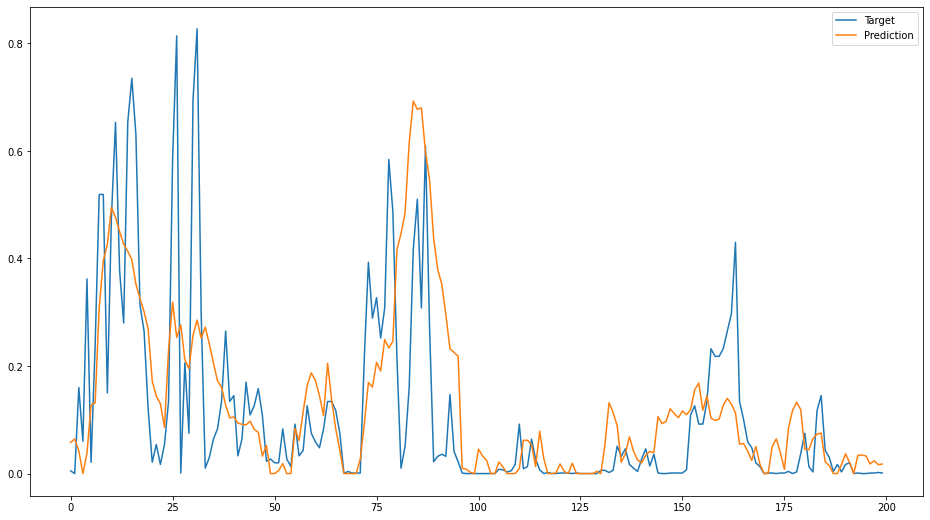

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(targets[0:200], label="Target")
plt.plot(preds[0:200], label="Prediction")
plt.legend()
# result_df[500:1000].plot(figsize=(16,9))